Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation, experimental

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


Using the datasource as Google drive. so mounted the google drive.

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
120


There are 2239 images are for trining and 120 images are for validating / testing the model.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
img_height = 180 # This should map with the height and width of the pretrained model
img_width = 180 # This should map with the height and width of the pretrained model

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    #labels='inferred', label_mode='int', class_names=None, color_mode='rgb',shuffle=True,, interpolation='bilinear', follow_links=False 
    batch_size=batch_size, 
    image_size=(img_height,img_width), 
    seed=123, 
    validation_split=0.2, 
    subset='training'
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    seed=123,
    validation_split=0.2,
    subset='validation'
)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

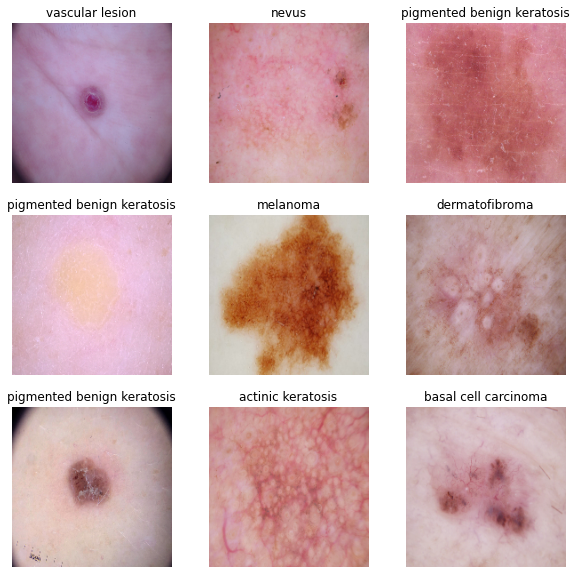

In [ ]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.046078194 0.75817025


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer='SGD',              
#              metrics=['accuracy'])
#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer='adam',
#              metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)       

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 678s 3s/step - loss: 2.0780 - accuracy: 0.1970 - val_loss: 1.8301 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.7374 - accuracy: 0.3786 - val_loss: 1.5048 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4468 - accuracy: 0.4991 - val_loss: 1.5637 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3813 - accuracy: 0.5112 - val_loss: 1.3922 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 1.2215 - accuracy: 0.5800 - val_loss: 1.3271 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1044 - accuracy: 0.5973 - val_loss: 1.5076 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0641 - accuracy: 0.6208 - val_loss: 1.3981 - val_accuracy: 0.5257
Epoch 8/20
56

### Visualizing training results

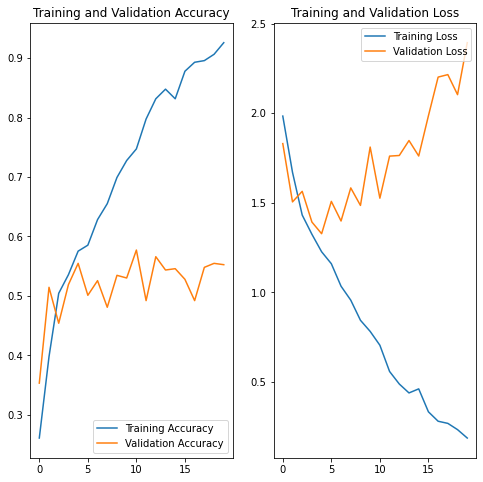

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

As per the CNN model and graph, it clearily showing that even though model is well trained and reaching with a good accuracy but when testing it with the validation set model is not working fine as accuracy is not upto mark only able to reach till 55. So model is seems overfits with the data. Let's try to add some more layer to our CNN model.

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [ ]:
#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer='SGD',              
#              metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 32)        1

### Training the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 1658s 9s/step - loss: 4.3911 - accuracy: 0.2366 - val_loss: 28.4384 - val_accuracy: 0.1284
Epoch 2/20
169/169 [==============================] - 42s 240ms/step - loss: 1.6477 - accuracy: 0.3894 - val_loss: 12.1617 - val_accuracy: 0.1180
Epoch 3/20
169/169 [==============================] - 41s 235ms/step - loss: 1.4361 - accuracy: 0.4555 - val_loss: 6.0840 - val_accuracy: 0.1819
Epoch 4/20
169/169 [==============================] - 41s 237ms/step - loss: 1.2288 - accuracy: 0.5352 - val_loss: 3.8574 - val_accuracy: 0.3133
Epoch 5/20
169/169 [==============================] - 41s 237ms/step - loss: 1.0369 - accuracy: 0.6068 - val_loss: 3.4214 - val_accuracy: 0.3920
Epoch 6/20
169/169 [==============================] - 42s 240ms/step - loss: 0.8514 - accuracy: 0.6727 - val_loss: 1.8616 - val_accuracy: 0.5345
Epoch 7/20
169/169 [==============================] - 41s 237ms/step - loss: 0.7041 - accuracy: 0.7324 - val_loss: 2.8349 - val_a

### Visualizing the results

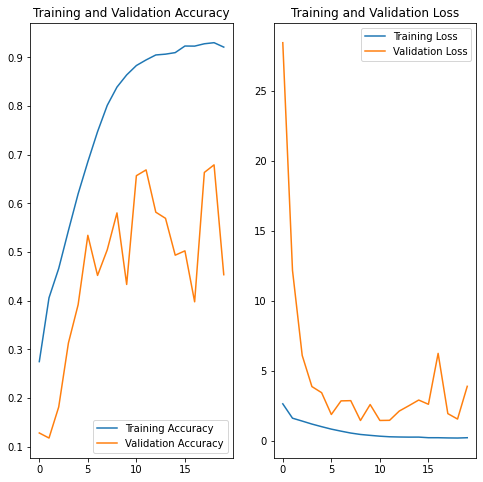

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Model is performing slightly better than previous model but as per chart. We can see as we are training our model with various numbers of epoches the validation accuracy increaing till a good amount but not is continous manner. There are some sudden drops as well. 
So need to train model with large dataset but since we are having limited data so will use augmentation for training the model over large dataset. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD4E0663E10>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD533EABB50>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD533C052D0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD535425050>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD4E06D8F10>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7FD535425150>:   0%|          | 1/500 [00:00<01:28,  5.62 Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FD5763E7590>: 100%|██████████| 500/500 [01:24<00:00,  5.90 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD533E40ED0>:   0%|          | 1/500 [00:00<01:36,  5.17 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD533E38490>: 100%|██████████| 500/500 [00:19<00:00, 25.84 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD4E0668050>: 100%|██████████| 500/500 [00:41<00:00, 11.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD535457210>: 100%|██████████| 500/500 [00:19<00:00, 25.24 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD5354DEE50>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

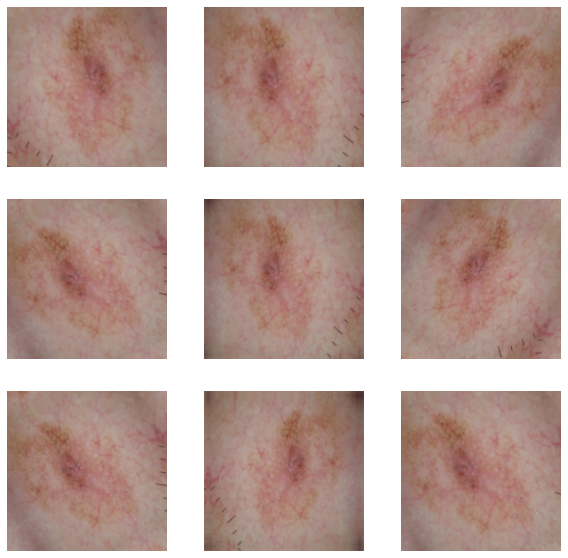

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from os import path
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list)

['/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_4d3e70d2-44cb-43b6-bfec-7b2e83e00247.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_1ca92993-4cae-47c1-b90f-cf0d2dc33238.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026709.jpg_90f8e977-f150-42e2-bd3a-b37d737680b4.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026905.jpg_2a0127a1-3119-4a67-b085-c3f004514ee8.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train_aug=glob.glob(os.path.join(data_dir_train, '*','*'))
print(data_dir_train_aug)

['/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025992.jpg', '/content/gdrive/MyDrive/Colab No

#### **Todo:** Create a training dataset

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 230ms/step - loss: 2.1631 - accuracy: 0.2156 - val_loss: 1.5355 - val_accuracy: 0.4254
Epoch 2/30
169/169 [==============================] - 39s 225ms/step - loss: 1.4255 - accuracy: 0.4557 - val_loss: 1.2680 - val_accuracy: 0.5249
Epoch 3/30
169/169 [==============================] - 39s 224ms/step - loss: 1.2170 - accuracy: 0.5497 - val_loss: 1.2031 - val_accuracy: 0.5642
Epoch 4/30
169/169 [==============================] - 39s 223ms/step - loss: 1.1029 - accuracy: 0.6031 - val_loss: 1.0431 - val_accuracy: 0.6244
Epoch 5/30
169/169 [==============================] - 39s 224ms/step - loss: 0.8846 - accuracy: 0.6697 - val_loss: 0.9421 - val_accuracy: 0.6622
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 0.7314 - accuracy: 0.7340 - val_loss: 0.8312 - val_accuracy: 0.7038
Epoch 7/30
169/169 [==============================] - 39s 225ms/step - loss: 0.6156 - accuracy: 0.7805 - val_loss: 1.0490 - val_ac

#### **Todo:**  Visualize the model results

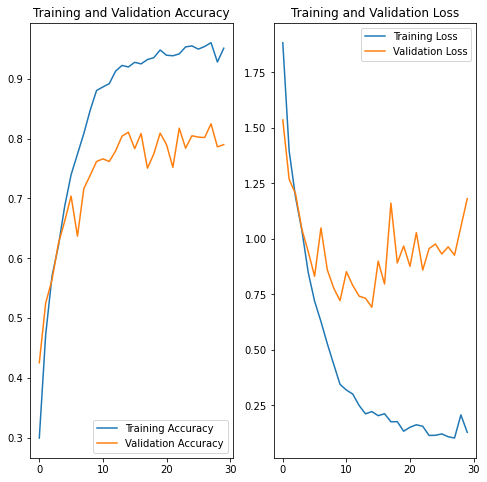

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Now our model is able to acheive good validation accuracy approx 80. and it is far better than our previous set of model accuracy. 
Model is performing well and able to predict in acceptable range. 